In [1]:
# ! pip install seaborn

In [1]:
import cudf  # GPU-accelerated DataFrame library
import cupy as cp  # GPU-based numerical computations
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    RBF,
    ConstantKernel as C,
    ExpSineSquared,
    WhiteKernel
)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load training data using cuDF
train = cudf.read_csv('/path/to/train.csv')
train['tip_amount'] = train['tip_amount'].fillna(0)
train['tpep_pickup_datetime'] = cudf.to_datetime(train['tpep_pickup_datetime'])
train = train.set_index('tpep_pickup_datetime')

In [4]:
# Add interval and time index columns
train['interval'] = cp.arange(1, len(train) + 1) % 48  # Get to hour interval
train['time_index'] = cp.arange(1, len(train) + 1)

In [5]:
# Limit to first 800 rows for training (convert to pandas for preview if needed)
# train = train.iloc[:800]
print(train.head().to_pandas())  # Convert to pandas for display

                      passenger_count  trip_distance  DOLocationID  \
tpep_pickup_datetime                                                 
2022-01-24 00:00:00              13.0          49.14          1583   
2022-01-24 00:30:00               9.0          51.99          1524   
2022-01-24 01:00:00              12.0          37.72          1242   
2022-01-24 01:30:00               7.0          11.99           785   
2022-01-24 02:00:00               7.0          15.40           998   

                      fare_amount  total_amount  tip_amount  pickup_count  \
tpep_pickup_datetime                                                        
2022-01-24 00:00:00        173.00        237.35       1.615            12   
2022-01-24 00:30:00        174.43        245.92       2.770             9   
2022-01-24 01:00:00        137.50        209.51       2.110            12   
2022-01-24 01:30:00         50.50         86.39       2.010             6   
2022-01-24 02:00:00         64.50         94.95

In [6]:
# Load testing data using cuDF
test = cudf.read_csv('/path/to/test.csv')
test['tip_amount'] = test['tip_amount'].fillna(0)
test['tpep_pickup_datetime'] = cudf.to_datetime(test['tpep_pickup_datetime'])
test = test.set_index('tpep_pickup_datetime')

In [7]:
# Add interval and time index columns
test['interval'] = cp.arange(1, len(test) + 1) % 48  # Get to hour interval
test['time_index'] = cp.arange(1, len(test) + 1)

In [8]:
# Limit to first 800 rows for testing (convert to pandas for preview if needed)
# test = test.iloc[:800]
print(test.head().to_pandas())  # Convert to pandas for display

                      passenger_count  trip_distance  DOLocationID  \
tpep_pickup_datetime                                                 
2024-01-22 00:00:00              13.0          24.75          1545   
2024-01-22 00:30:00              17.0          22.92          1645   
2024-01-22 01:00:00              15.0          35.45          2733   
2024-01-22 01:30:00               9.0          19.71          1280   
2024-01-22 02:00:00               8.0          14.74           617   

                      fare_amount  total_amount  tip_amount  pickup_count  \
tpep_pickup_datetime                                                        
2024-01-22 00:00:00         137.1        201.46        0.00            10   
2024-01-22 00:30:00         122.1        193.90        0.00            14   
2024-01-22 01:00:00         194.8        305.46        2.58            15   
2024-01-22 01:30:00         104.0        160.07        1.00             9   
2024-01-22 02:00:00          78.9        114.34

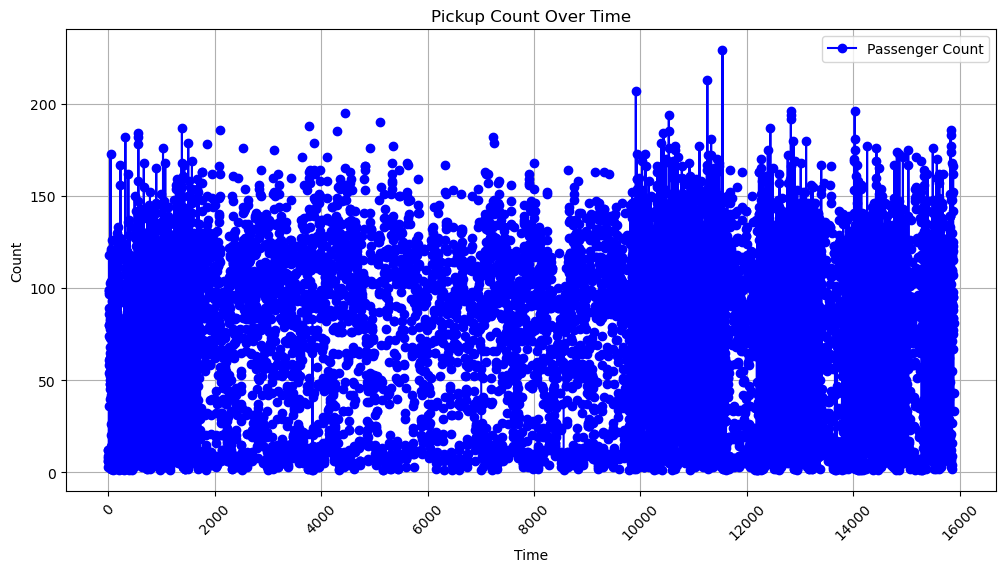

In [9]:
# Visualization (convert cuDF to pandas for plotting)
plt.figure(figsize=(12, 6))
plt.plot(train['time_index'].to_pandas(), train['pickup_count'].to_pandas(), marker='o', label='Passenger Count', color='blue')
plt.title('Pickup Count Over Time')
plt.xlabel('Time')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

In [10]:
# Ensure no nulls in 'pickup_count' by filling missing values with 0
train['pickup_count'] = train['pickup_count'].fillna(0)
test['pickup_count'] = test['pickup_count'].fillna(0)

In [11]:
# Features (X) - All columns except 'pickup_count'
X_train = train[['interval', 'weekday']].to_cupy()  # Convert cuDF to CuPy array
X_test = test[['interval', 'weekday']].to_cupy()    # Convert cuDF to CuPy array

In [12]:
# Compute the mean of 'pickup_count' for centering
mean_func = train['pickup_count'].mean()

# Convert 'pickup_count' to CuPy arrays and center the target variable
# Target (y) - 'pickup_count'
y_train = train['pickup_count'].to_cupy() - mean_func  # Center target variable
y_test = test['pickup_count'].to_cupy() - mean_func

In [13]:
# Scale features using StandardScaler (remains on CPU)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(cp.asnumpy(X_train))  # Convert CuPy array to NumPy for scaling
X_test_scaled = scaler.transform(cp.asnumpy(X_test))       # Convert CuPy array to NumPy for scaling

In [14]:
# Convert scaled features back to CuPy arrays for GPU processing
X_train_scaled_gpu = cp.asarray(X_train_scaled)
X_test_scaled_gpu = cp.asarray(X_test_scaled)

In [15]:
# Define the GP kernel
kernel = (
    C(10.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)) +
    C(50.0, (1e-3, 1e3)) * ExpSineSquared(length_scale=1.0, periodicity=336, periodicity_bounds=(1e-2, 1e2)) +
    WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-5, 100000.0))
)

In [16]:
# Instantiate and fit the Gaussian Process Regressor
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=50, alpha=1e-5)
gp.fit(cp.asnumpy(X_train_scaled_gpu), cp.asnumpy(y_train))  # Convert CuPy arrays to NumPy for fitting

print("Fit Complete")
print("Learned Kernel:", gp.kernel_)

KeyboardInterrupt: 

In [ ]:
# Make predictions (add mean back)
y_pred, sigma = gp.predict(cp.asnumpy(X_test_scaled_gpu), return_std=True)

In [ ]:
# Evaluate the model
rmse = mean_squared_error(cp.asnumpy(y_test), y_pred, squared=False)
r2 = r2_score(cp.asnumpy(y_test), y_pred)
print(f"Root Mean Squared Error: {rmse:.3f}")
print(f"R^2 Score: {r2:.3f}")

Root Mean Squared Error: 34.709
R^2 Score: 0.423


/ext3/miniforge3/envs/rapids-24.10/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
# Visualization of predictions vs true values
plt.figure(figsize=(12, 6))
plt.scatter(range(len(y_test)), cp.asnumpy(y_test), label="True Values", color="blue", alpha=0.6)
plt.plot(range(len(y_pred)), y_pred, label="GP Predictions", color="red", linestyle="dashed")
plt.fill_between(
    range(len(y_pred)),
    y_pred - 1.96 * sigma,
    y_pred + 1.96 * sigma,
    color="lightgrey",
    alpha=0.5,
    label="95% Confidence Interval",
)
plt.xlabel("Sample Index")
plt.ylabel("Pickup Count")
plt.title("Gaussian Process Regression: Pickup Count Prediction")
plt.legend()
plt.show()

In [ ]:
# Residual plot
residuals = cp.asnumpy(y_test) - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='blue')
plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
plt.xlabel('Predicted Pickup Count')
plt.ylabel('Residuals')
plt.title('Residual Plot (Predicted vs Error)')
plt.legend()
plt.grid(True)
plt.show()